# Graph Analyses of the SDSS Skeleton Galaxies 

## Problem Description:

Measuring **graph statistics** of the **SDSS Skeleton galaxies** using *python-igraph* and *pyspark*'s parallel computation capability. 

#### Key Steps : 
* generating cKDTree using 3-d positions of SDSS galaxies
* generating graph edges using cKDTree for a certain linking length, such 1.0 Mpc/h
* parallelize graph calculations for various `linklen` using PySpark/UDF. For this, we will broadcast two dataframes, one the galaxy catalog `galdf` and the other kdtree `galkdtree`



## Solve the problem: 
### 1. Read and visualize data 

- comments :  *pandas* is a nice tool for handling tabular data, and easy to be converted to Spark's Dataframe!

In [1]:
# generate edges 
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree


# plot settings
plt.rc('font', family='serif') 
plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 16})
plt.rcParams['mathtext.fontset'] = 'stix'



In [2]:
# galaxy dataframe 
galdf = pd.read_csv("./D2018Mar_SDSSvolskbfHR4.txt",delimiter=r"\s+")

galdf.describe()


,id,px,py,pz,ra,dec,z
count,1.409510e+05,140951.000000,140951.000000,140951.000000,140951.000000,140951.000000,140951.000000
mean,1.237606e+18,-180.314027,-26.419503,112.496129,188.081451,27.550557,0.087145
std,5.996145e+15,69.606056,116.863562,76.121206,33.320489,17.858854,0.022923
min,5.877297e+17,-344.442000,-284.817000,-5.991000,113.353752,-0.997683,0.020000
25%,1.237658e+18,-232.628000,-116.723000,48.269500,161.376974,12.038131,0.072700
50%,1.237662e+18,-178.780000,-23.007000,105.113000,187.177357,26.697691,0.090600
75%,1.237665e+18,-126.119500,60.534500,166.520500,217.149046,40.858461,0.106800
max,1.237675e+18,-13.143000,245.740000,319.691000,258.514729,68.731483,0.117800


In [3]:
galdf.head()

,id,px,py,pz,ra,dec,z
0,1237648703516967076,-231.093,-159.347,-3.651,214.587707,-0.745185,0.0955
1,1237648720716431639,-112.528,-141.735,-1.888,231.552612,-0.597845,0.0611
2,1237648720716562576,-207.169,-263.017,-2.648,231.773673,-0.453146,0.1143
3,1237648720716562641,-97.888,-124.632,-1.228,231.853275,-0.444057,0.0534
4,1237648703517360304,-202.499,-143.760,-3.457,215.371979,-0.797497,0.0843


In [4]:
# how to "select" data using multiple criteria 
# Key Point : use `(condition1) & (condition2)`
galdf[(galdf["pz"] < 20.0) & (galdf["pz"] > -20.0)].pz.values

array([-3.651, -1.888, -2.648, ..., -1.505, -5.051, -2.979])

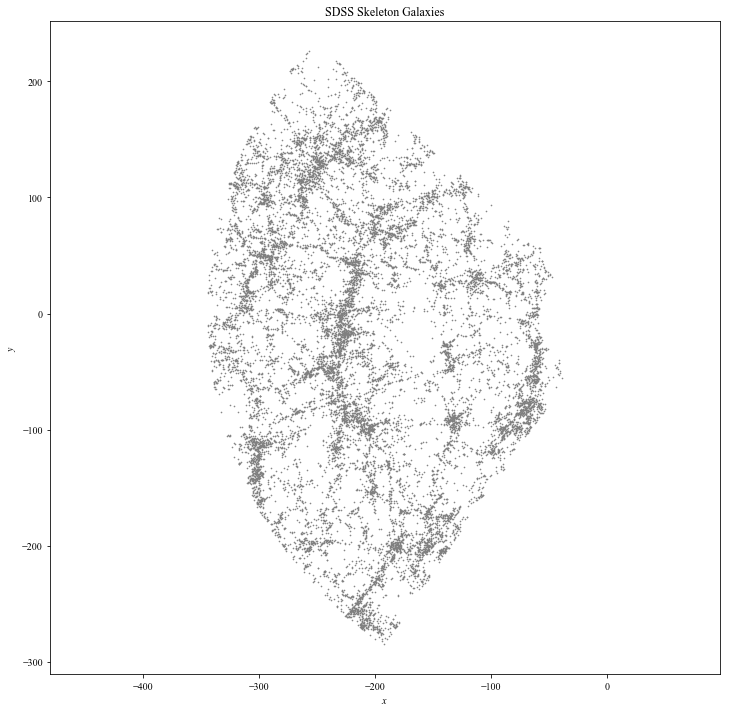

In [5]:
# 
# 3d point distribution on a sphere
#

fig = plt.figure(figsize=(12,12))

#plt.axis([-1,1,-1,1])
plt.axes().set_aspect('equal', 'datalim')
plt.title(r'SDSS Skeleton Galaxies')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.scatter(galdf[np.abs(galdf.pz.values) < 20.].px.values,\
            galdf[np.abs(galdf.pz.values) < 20.].py.values,s=1.5,marker=".", color='grey')

plt.show()

In [6]:
#
# using earth-map api_s for utilizing various projections 
#
"""
from mpl_toolkits.basemap import Basemap


fig = plt.figure(figsize=(13,12))

m = Basemap(projection='ortho',lat_0=27,lon_0=260)
x, y = m(galdf.ra.values,galdf.dec.values)
m.scatter(x,y,s=2,marker='o',color='grey',alpha=0.5)
m.drawmeridians(np.arange(0,360,30))
m.drawparallels(np.arange(-90,90,30))


plt.title(r'SDSS Skeleton Galaxies')
#fig.savefig("visSDSS.png")
plt.show()
"""

'\nfrom mpl_toolkits.basemap import Basemap\n\n\nfig = plt.figure(figsize=(13,12))\n\nm = Basemap(projection=\'ortho\',lat_0=27,lon_0=260)\nx, y = m(galdf.ra.values,galdf.dec.values)\nm.scatter(x,y,s=2,marker=\'o\',color=\'grey\',alpha=0.5)\nm.drawmeridians(np.arange(0,360,30))\nm.drawparallels(np.arange(-90,90,30))\n\n\nplt.title(r\'SDSS Skeleton Galaxies\')\n#fig.savefig("visSDSS.png")\nplt.show()\n'

### 2. Building a KDtree and Generating FOF networks for various linking lengths

- Defining a function measuring angular separation between two polar coordinates for 2-d data

In [7]:
# define a spherical distance function
# angular distance between two polar coordinates : (phi,theta)
def polarangdist (p1,t1,p2,t2,debug=False) :
    innerproduct = np.sin(np.radians(t1))*np.cos(np.radians(p1))*np.sin(np.radians(t2))*np.cos(np.radians(p2))\
    + np.sin(np.radians(t1))*np.sin(np.radians(p1))*np.sin(np.radians(t2))*np.sin(np.radians(p2))\
    + np.cos(np.radians(t1)) * np.cos(np.radians(t2))
    
    if np.abs(innerproduct) > 1.:
        if np.abs(innerproduct) < 1.001:
            innerproduct = 1.0
            if debug:
                print "Minor roundoff issue in polarangdist : set innerproduct = 1.0"
        else:
            print "Funny things happen in polarangdist" 
            sys.exit(1)
    
    return np.degrees(np.arccos(innerproduct))

- Making a cKDTree using 3d coordinates

In [8]:
# now generate a kdtree for finding nearest neighbor

galkdtree = cKDTree(galdf[['px','py','pz']])
sys.getsizeof(galkdtree)

208

In [9]:
sys.getsizeof(galdf)

7893360

In [10]:
# let's test how scipy/kdtree works 
galkdtree.query(galdf.loc[4,['px','py','pz']],k=[2])

(array([2.72015404]), array([83525]))

#### Generating a FOF network and testing this Python/igraph with C/C++ igraph as a sanity check

In [11]:
# 
# Generate a FOF network using the KDtree above 
# 
# 

from igraph import *

#angcut = 0.1 # in degree
lengcut = 5.0 # in [1/h Mpc]

inearest = 1
#numtotal = len(galdf.index)
numtotal = 5
thisangdist = 0.

edgelists = []



for ivertex in range(numtotal):
    inearest=2 # this is the first nearest neighbor in kdtree 
    dummy, inow = galkdtree.query(galdf.loc[ivertex,['px','py','pz']],k=[inearest])
    """
    thisangdist= polarangdist(hotdf.loc[ivertex,['phi']].values[0],hotdf.loc[ivertex,['theta']].values[0],\
                           hotdf.loc[inow[0],['phi']].values[0],hotdf.loc[inow[0],['theta']].values[0],\
                             debug=True)"""

    #while (thisangdist <= angcut):
    while (dummy[0] <= lengcut):
        #print ivertex, inow[0], " : ",  dummy[0], inearest, " : sphdist = ", thisangdist 
        #print ivertex, inow[0], " : ",  dummy[0], inearest
        #print galdf.loc[ivertex,['ra']].values[0]
        #print galdf.loc[ivertex,['ra','dec','px','py','pz']]
        #print galdf.loc[inow[0],['ra']].values[0]
        #print galdf.loc[inow[0],['ra','dec','px','py','pz']]
        
        edgelists.append([ivertex,inow[0]])

        
        inearest = inearest + 1 # the next nearest one 
        dummy, inow = galkdtree.query(galdf.loc[ivertex,['px','py','pz']],k=[inearest])
        
        """
        thisangdist = polarangdist(hotdf.loc[ivertex,['phi']].values[0],hotdf.loc[ivertex,['theta']].values[0],\
                                   hotdf.loc[inow[0],['phi']].values[0],hotdf.loc[inow[0],['theta']].values[0],\
                                   debug=True)"""

print edgelists[:20]

[[2, 94988], [2, 87188], [2, 90978], [2, 90980], [2, 96135], [3, 90252], [4, 83525], [4, 95145], [4, 89714], [4, 95133], [4, 95134], [4, 95132]]


### It is time to parallelize the graph calculations using PySpark.

In [12]:
import gc
gc.collect()

73

In [13]:
from pyspark import SparkContext   
from pyspark.sql import SQLContext

#sc = SparkContext(master='local[3]', appName='calgraph')
sqlsc = SQLContext(sc)
#sc.setCheckpointDir("./checkpoints")
#sc.setCheckpointDir("hdfs://localhost:8020/myhdfs/spark/checkpoints")
sc.setCheckpointDir("hdfs://master:54310/tmp/spark/checkpoints")



In [14]:
## Define basic index and linking length dataframe

#ilink = np.arange(1,20) 
#linklen = np.arange(1,20)*0.2 + 0.2
#ilink = np.arange(1,4) 
#linklen = np.arange(1,4)*0.5

ilink = np.arange(1,60) 
linklen = np.arange(1,60)*0.1 + 0.1


print ilink 
print linklen
numdata = len(linklen)



linkdf = pd.DataFrame(list(zip(ilink, linklen)),\
                      columns=['ilink','linklen'])

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59]
[0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9
 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5 3.6 3.7
 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5.  5.1 5.2 5.3 5.4 5.5
 5.6 5.7 5.8 5.9 6. ]


#### Broadcast the kdtree to workers / Load pandasDF to sparkDF

In [15]:
## Now, setting for pyspark 
bcastgalkdtree = sc.broadcast(galkdtree)
bcastgaldf =sc.broadcast(galdf)
sparkdf = sqlsc.createDataFrame(linkdf).persist()

sparkdf.printSchema()

root
 |-- ilink: long (nullable = true)
 |-- linklen: double (nullable = true)



In [16]:
sparkdf.show(5,truncate=True)

+-----+-------------------+
|ilink|            linklen|
+-----+-------------------+
|    1|                0.2|
|    2|0.30000000000000004|
|    3|                0.4|
|    4|                0.5|
|    5|                0.6|
+-----+-------------------+
only showing top 5 rows



* Key Feature : broadcasted `object` needs this prefix(?) `.value` for accessing to its own attributes. 

In [17]:
## Define an UDF for applying this to the `linklen` column 
def testPassingBcastVariable(linklen, curgaldf, curtree):
    dummy, inow = curtree.value.query(curgaldf.value.loc[4,['px','py','pz']],k=[2])
    #dummy, inow = curtree.query([104.,179.,-136.],k=[2])
    return dummy[0].item()

def temp(linklen, curgaldf, curtree):
    dummy, inow = curtree.query(curgaldf.loc[4,['px','py','pz']],k=[2])
    #dummy, inow = curtree.query([104.,179.,-136.],k=[2])
    return dummy[0].item()


In [18]:
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark import Row

from functools import partial
testudf = F.udf(partial(testPassingBcastVariable, curtree = bcastgalkdtree, curgaldf = bcastgaldf),\
                 T.DoubleType())
#graphudf = F.udf(getGraphStatistics, T.DoubleType())


In [19]:
tmpudf = F.udf(lambda x: x*x, T.DoubleType())

In [20]:
#getGraphStatistics(0.5,galdf,galkdtree)
type(temp(0.5,galdf,galkdtree))

float

In [21]:
galkdtree.query([104.,179.,-136.],k=[2])

(array([249.80890392]), array([140863]))

In [22]:
bcastgalkdtree.value.query([104.,179.,-136.],k=[2])

(array([249.80890392]), array([140863]))

In [23]:
bcastgaldf.value.loc[4,['px','py','pz']]

px   -202.499
py   -143.760
pz     -3.457
Name: 4, dtype: float64

In [24]:
sparkdf.withColumn('tmp',tmpudf('linklen')).show(5)

+-----+-------------------+-------------------+
|ilink|            linklen|                tmp|
+-----+-------------------+-------------------+
|    1|                0.2|0.04000000000000001|
|    2|0.30000000000000004|0.09000000000000002|
|    3|                0.4|0.16000000000000003|
|    4|                0.5|               0.25|
|    5|                0.6|               0.36|
+-----+-------------------+-------------------+
only showing top 5 rows



In [25]:
testdf = sparkdf.withColumn('gstat',testudf('linklen'))
testdf.persist().printSchema()

root
 |-- ilink: long (nullable = true)
 |-- linklen: double (nullable = true)
 |-- gstat: double (nullable = true)



In [26]:
print len(bcastgaldf.value.index)

140951


#### Now, define the right UDF and let calculations done!

* Key Point : `gStats` gets inputs of one column variable `linklen` from dataframe and two broadcasted dataframes `curgaldf` and `curtree`. Hence, got a column and apply this UDF with two passed broadcasted dataframe arguments. 

* Key Note : The `numpy` types are not compatible with `Spark's UDF`. Hence, `return` with `numpyObject.item()` by converting them to generic python types.

In [27]:
# curgaldf and curtree are Broadcasted Variables. Hence, they need ".value" 
def gStats(linklen, curgaldf, curtree):
    lengcut = linklen
    
    inearest = 1
    numtotal = len(curgaldf.value.index)
    thisangdist = 0.
    
    edgelists = []
    g = Graph()
    
    
    for ivertex in range(numtotal):    
        
        inearest=2 # this is the first nearest neighbor in kdtree 

        dummy, inow = curtree.value.query(curgaldf.value.loc[ivertex,['px','py','pz']],k=[inearest])
        """thisangdist= polarangdist(hotdf.loc[ivertex,['phi']].values[0],hotdf.loc[ivertex,['theta']].values[0],\
                                  hotdf.loc[inow[0],['phi']].values[0],hotdf.loc[inow[0],['theta']].values[0],\
                                  debug=False)"""
        
        #while (thisangdist <= angcut):
        while (dummy[0] <= lengcut):
            
            edgelists.append([ivertex,inow[0]])
            inearest = inearest + 1 # the next nearest one 
            dummy, inow = curtree.value.query(curgaldf.value.loc[ivertex,['px','py','pz']],k=[inearest])
            
            """thisangdist = polarangdist(hotdf.loc[ivertex,['phi']].values[0],hotdf.loc[ivertex,['theta']].values[0],\
                                       hotdf.loc[inow[0],['phi']].values[0],hotdf.loc[inow[0],['theta']].values[0],\
                                       debug=False)"""
   

    # make a graph and do the jobs
    g = Graph(edgelists)
    
    transitivity = g.transitivity_undirected()
    diameter = np.double(g.diameter()).item()
    localcc = g.transitivity_avglocal_undirected()
    numclique = np.double(g.clique_number()).item()
    subcomp = g.components()
    gcompfrac = np.double(np.max(subcomp.sizes()))/np.double(g.vcount())
    numsubcomptwo = len(list(filter(lambda size: size >= 2, subcomp.sizes())))
    maxdg = np.max(g.degree())
    dgcent = np.double(np.sum(maxdg-g.degree()))/((g.vcount() - 2) * (g.vcount() - 1))

    
    return [diameter,transitivity,localcc,numclique,gcompfrac.item(),\
            np.double(numsubcomptwo).item(),dgcent.item()]




In [28]:
"""
%%time
tmpout = gStats(1.0,bcastgaldf,bcastgalkdtree)
"""

'\n%%time\ntmpout = gStats(1.0,bcastgaldf,bcastgalkdtree)\n'

In [29]:
# check the return types, which should be compatible for Spark/UDF's return types
#type(tmpout[6])

In [30]:
#tmpout

In [31]:
gstatudf = F.udf(partial(gStats, curtree = bcastgalkdtree, curgaldf = bcastgaldf),\
                 T.ArrayType(T.DoubleType()))

In [32]:
sparkdf.show()

+-----+-------------------+
|ilink|            linklen|
+-----+-------------------+
|    1|                0.2|
|    2|0.30000000000000004|
|    3|                0.4|
|    4|                0.5|
|    5|                0.6|
|    6| 0.7000000000000001|
|    7|                0.8|
|    8|                0.9|
|    9|                1.0|
|   10|                1.1|
|   11| 1.2000000000000002|
|   12| 1.3000000000000003|
|   13| 1.4000000000000001|
|   14| 1.5000000000000002|
|   15|                1.6|
|   16| 1.7000000000000002|
|   17| 1.8000000000000003|
|   18| 1.9000000000000001|
|   19|                2.0|
|   20|                2.1|
+-----+-------------------+
only showing top 20 rows



In [33]:
# Let's do the jobs on workers 
%time

gstatdf = sparkdf.withColumn('gstat',gstatudf('linklen')).cache()


CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 10 µs


In [34]:
%time gstatdf.collect()

CPU times: user 493 ms, sys: 201 ms, total: 694 ms
Wall time: 3h 37min 57s


[Row(ilink=1, linklen=0.2, gstat=[2.0, 0.6818181818181818, 0.6818181818181818, 3.0, 2.128414331323164e-05, 965.0, 2.8181741798609826e-05]),
 Row(ilink=2, linklen=0.30000000000000004, gstat=[3.0, 0.6078431372549019, 0.6253041362530413, 3.0, 3.5473572188719404e-05, 2225.0, 4.209824864043306e-05]),
 Row(ilink=3, linklen=0.4, gstat=[4.0, 0.6123711340206186, 0.6039304610733183, 4.0, 4.256828662646328e-05, 4000.0, 4.168992264900944e-05]),
 Row(ilink=4, linklen=0.5, gstat=[4.0, 0.6206896551724138, 0.6203869047619048, 4.0, 4.966300106420717e-05, 6133.0, 5.5333406786508e-05]),
 Row(ilink=5, linklen=0.6, gstat=[4.0, 0.5869332381292396, 0.5912691269126913, 4.0, 4.966300106420717e-05, 8607.0, 6.882004380994395e-05]),
 Row(ilink=6, linklen=0.7000000000000001, gstat=[8.0, 0.6108547166328226, 0.6212113489636425, 5.0, 7.804185881518269e-05, 11057.0, 8.219533750337138e-05]),
 Row(ilink=7, linklen=0.8, gstat=[8.0, 0.6249085015162605, 0.6309826749188965, 6.0, 0.00012061014544164598, 13577.0, 9.5412978706

In [35]:
#show each DoubleType in the `gstat` ArrayType
%time gstatdf.select(F.col("gstat").getItem(1)).show()

+------------------+
|          gstat[1]|
+------------------+
|0.6818181818181818|
|0.6078431372549019|
|0.6123711340206186|
|0.6206896551724138|
|0.5869332381292396|
|0.6108547166328226|
|0.6249085015162605|
|0.6221843649441605|
|0.6290461185906617|
|0.6264353572903759|
|0.6298310797870303|
|0.6294099672204011|
|0.6306529308449995|
|0.6339399855891035|
|0.6365304061523385|
|0.6358565289967223|
|0.6378122579664923|
|0.6362194990863163|
|0.6362854144297213|
|0.6372862737606266|
+------------------+
only showing top 20 rows

CPU times: user 2.79 ms, sys: 1.61 ms, total: 4.39 ms
Wall time: 184 ms


# 3. Results

* Now, **collect** the results `gstatdf` (**spark/dataframe**) to `gstatpd` (**pandas/dataframe**) 

In [40]:
gstatpd = gstatdf.select("ilink","linklen").toPandas()

In [41]:
gstatpd.head()

,ilink,linklen
0,1,0.2
1,2,0.3
2,3,0.4
3,4,0.5
4,5,0.6


In [42]:
tmppd = gstatdf.select(F.col("gstat").getItem(1).alias("transitivity")).toPandas()

In [43]:
re = pd.merge(gstatpd,\
         gstatdf.select(F.col("gstat").getItem(0).alias("diameter")).toPandas(),\
         left_index=True,right_index=True)
re = pd.merge(re,\
         gstatdf.select(F.col("gstat").getItem(1).alias("transitivity")).toPandas(),\
         left_index=True,right_index=True)
re = pd.merge(re,\
         gstatdf.select(F.col("gstat").getItem(2).alias("localcc")).toPandas(),\
         left_index=True,right_index=True)
re = pd.merge(re,\
         gstatdf.select(F.col("gstat").getItem(3).alias("numclique")).toPandas(),\
         left_index=True,right_index=True)
re = pd.merge(re,\
         gstatdf.select(F.col("gstat").getItem(4).alias("gcomp")).toPandas(),\
         left_index=True,right_index=True)
re = pd.merge(re,\
         gstatdf.select(F.col("gstat").getItem(5).alias("subcomp")).toPandas(),\
         left_index=True,right_index=True)
re = pd.merge(re,\
         gstatdf.select(F.col("gstat").getItem(6).alias("dgcent")).toPandas(),\
         left_index=True,right_index=True)
re.head()

,ilink,linklen,diameter,transitivity,localcc,numclique,gcomp,subcomp,dgcent
0,1,0.2,2.0,0.681818,0.681818,3.0,0.000021,965.0,0.000028
1,2,0.3,3.0,0.607843,0.625304,3.0,0.000035,2225.0,0.000042
2,3,0.4,4.0,0.612371,0.603930,4.0,0.000043,4000.0,0.000042
3,4,0.5,4.0,0.620690,0.620387,4.0,0.000050,6133.0,0.000055
4,5,0.6,4.0,0.586933,0.591269,4.0,0.000050,8607.0,0.000069


In [44]:
re.describe()

,ilink,linklen,diameter,transitivity,localcc,numclique,gcomp,subcomp,dgcent
count,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000
mean,30.000000,3.100000,135.559322,0.636446,0.661771,22.169492,0.264846,11681.186441,0.000654
std,17.175564,1.717556,119.037124,0.011853,0.020186,13.510089,0.362799,7859.349671,0.000478
min,1.000000,0.200000,2.000000,0.586933,0.591269,3.000000,0.000021,965.000000,0.000028
25%,15.500000,1.650000,26.500000,0.636252,0.654266,11.000000,0.000798,4237.000000,0.000224
50%,30.000000,3.100000,95.000000,0.639962,0.671412,20.000000,0.015310,10467.000000,0.000576
75%,44.500000,4.550000,219.500000,0.641001,0.674604,32.500000,0.636097,19020.000000,0.001076
max,59.000000,6.000000,381.000000,0.681818,0.681818,49.000000,0.929436,24297.000000,0.001588


In [45]:
import pickle

with open('SDSSGraphSpark.pickle','wb') as f:
    pickle.dump(re,f)
f.close() #keep dumping the current results to overwrite the pickle. 

* Now plot the results

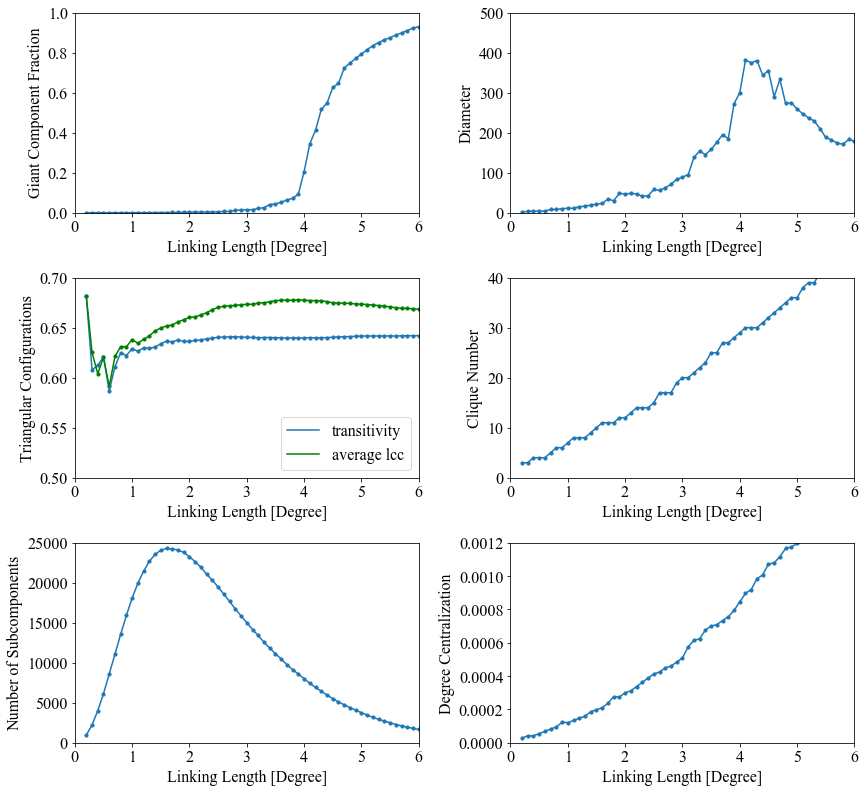

In [46]:
import matplotlib.pyplot as plt

# plot settings
plt.rc('font', family='serif') 
plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 16})
plt.rcParams['mathtext.fontset'] = 'stix'


lenmax = 6.0

fig = plt.figure(figsize=(12,11))

plt.subplot(321)
plt.axis([0,lenmax,0,1.0])
#plt.title("Diameter")
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel(r'Linking Length [Degree]')
plt.ylabel(r'Giant Component Fraction')
plt.scatter(re.linklen.values,re.gcomp.values,s=10)
plt.plot(re.linklen.values,re.gcomp.values)
#plt.text(0.2,0.4,'CMB COLD Spots',color='b')


plt.subplot(322)
plt.axis([0,lenmax,0,500])
#plt.title("Diameter")
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel(r'Linking Length [Degree]')
plt.ylabel(r'Diameter')
plt.scatter(re.linklen.values,re.diameter.values,s=10)
plt.plot(re.linklen.values,re.diameter.values)

plt.subplot(323)
plt.axis([0,lenmax,0.5,0.7])
#plt.title("Diameter")
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel(r'Linking Length [Degree]')
plt.ylabel(r'Triangular Configurations')
plt.plot(re.linklen.values,re.transitivity.values,label='transitivity')
plt.scatter(re.linklen.values,re.transitivity.values,s=10)
plt.plot(re.linklen.values,re.localcc.values,color='green',label='average lcc')
plt.scatter(re.linklen.values,re.localcc.values,color='green',s=10)
plt.legend(loc=4)

plt.subplot(324)
plt.axis([0,lenmax,0,40])
#plt.title("Diameter")
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel(r'Linking Length [Degree]')
plt.ylabel(r'Clique Number')
plt.scatter(re.linklen.values,re.numclique.values,s=10)
plt.plot(re.linklen.values,re.numclique.values)

plt.subplot(325)
plt.axis([0,lenmax,0,25000])
#plt.title("Diameter")
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel(r'Linking Length [Degree]')
plt.ylabel(r'Number of Subcomponents')
plt.scatter(re.linklen.values,re.subcomp.values,s=10)
plt.plot(re.linklen.values,re.subcomp.values)

plt.subplot(326)
plt.axis([0,lenmax,0,0.0012])
#plt.title("Diameter")
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel(r'Linking Length [Degree]')
plt.ylabel(r'Degree Centralization')
plt.scatter(re.linklen.values,re.dgcent.values,s=10)
plt.plot(re.linklen.values,re.dgcent.values)




plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
fig.savefig("graphSparkSDSS.eps")
plt.show()
